In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.preprocessing import StandardScaler



In [53]:
# pd.read_csv('X_modificado.csv')
# pd.read_csv('Z_modificado.csv')
datos_originales_conjunto_1 = pd.read_csv('Yb_train_dataset.csv', delimiter=',')
datos_originales_conjunto_2 = pd.read_csv('Yb_test_dataset.csv', delimiter=',')


In [54]:
# convertir la fecha de DD/MM/YYYY a YYYY-MM-DD

df = pd.DataFrame(datos_originales_conjunto_1)

# AGREGAR ENCABEZADOS 'DATE' Y 'PRICE' A ESTE DATAFRAME
df.columns = ['Date', 'Price']
df


,Date,Price
0,1.0,555.00
1,2.0,555.00
2,3.0,555.00
3,5.0,555.00
4,6.0,555.00
...,...,...
3357,4476.0,545.00
3358,4477.0,551.58
3359,4478.0,553.33
3360,4480.0,552.50


In [55]:


# aquí no se tiene un formato de fecha sino el conteo de días en la primera columna
# ESO ES LA MEDIDA TEMPORAL QUE LE VAMOS A PASAR A XGBOOST
# entonces usa 'Date' convertido a int como la medida temporal

# cambiar tipo de dato de la columna 'DATE' a int

df['Date'] = df['Date'].astype(int)
df

,Date,Price
0,1,555.00
1,2,555.00
2,3,555.00
3,5,555.00
4,6,555.00
...,...,...
3357,4476,545.00
3358,4477,551.58
3359,4478,553.33
3360,4480,552.50


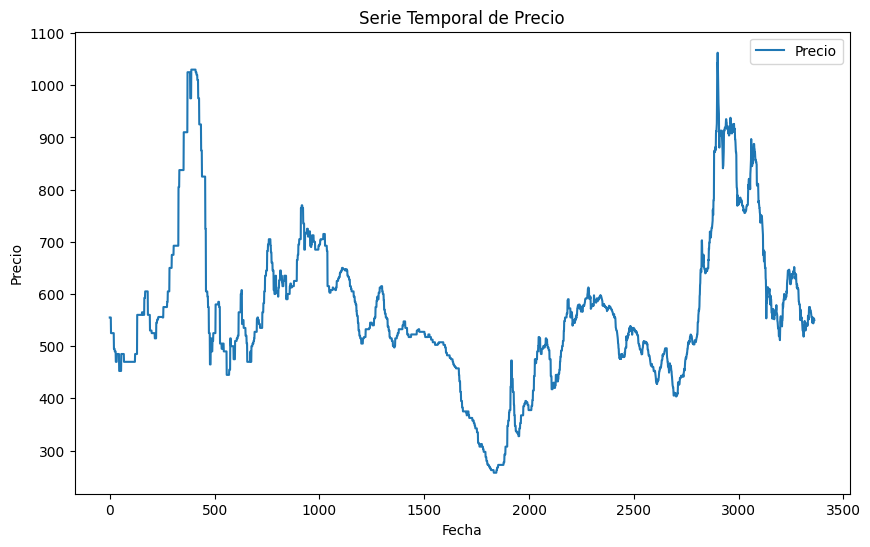

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(df['Price'], label='Precio')
plt.title('Serie Temporal de Precio')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()


Error cuadrático medio (MSE): 371.13565224063814


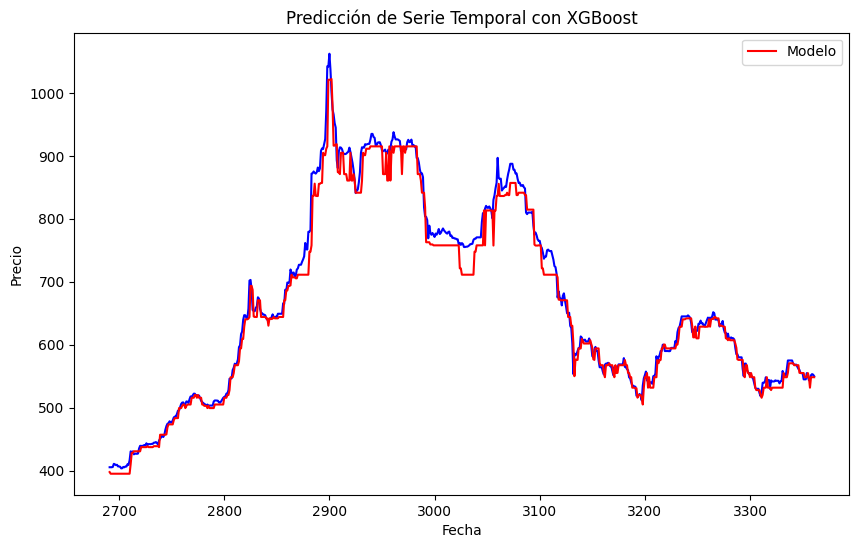

In [57]:
# Crear características de serie temporal (lag features)
def create_lag_features(df, lags=9):
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['Price'].shift(lag)
    df = df.dropna()  # Eliminar filas con valores nulos
    return df

# Crear características de lag
df = create_lag_features(df, lags=9)

# Dividir los datos en conjunto de entrenamiento y prueba
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Separar las características (X) y el target (y)
X_train = train.drop(columns=['Price'])
y_train = train['Price']
X_test = test.drop(columns=['Price'])
y_test = test['Price']

# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=400, max_depth=1, learning_rate=0.1)

# Entrenar el modelo
model.fit(X_train_scaled, y_train)

# Hacer predicciones
predictions = model.predict(X_test_scaled)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, predictions)
print(f"Error cuadrático medio (MSE): {mse}")

# Graficar las predicciones y los valores reales
plt.figure(figsize=(10, 6))
plt.plot(test.index, y_test, label='', color='blue')
plt.plot(test.index, predictions, label='Modelo', color='red')
plt.title('Predicción de Serie Temporal con XGBoost')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()



C:\Users\quint.LAPTOP-LGVR2QRN\AppData\Local\Temp\ipykernel_19260\562354197.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lag_{lag}'] = df['Price'].shift(lag)
C:\Users\quint.LAPTOP-LGVR2QRN\AppData\Local\Temp\ipykernel_19260\3586002629.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['Prediction'] = model.predict(X_future_scaled)
C:\Users\quint.LAPTOP-LGVR2QRN\AppData\Local\Temp\ipykernel_19260\3586002629.py:18: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  

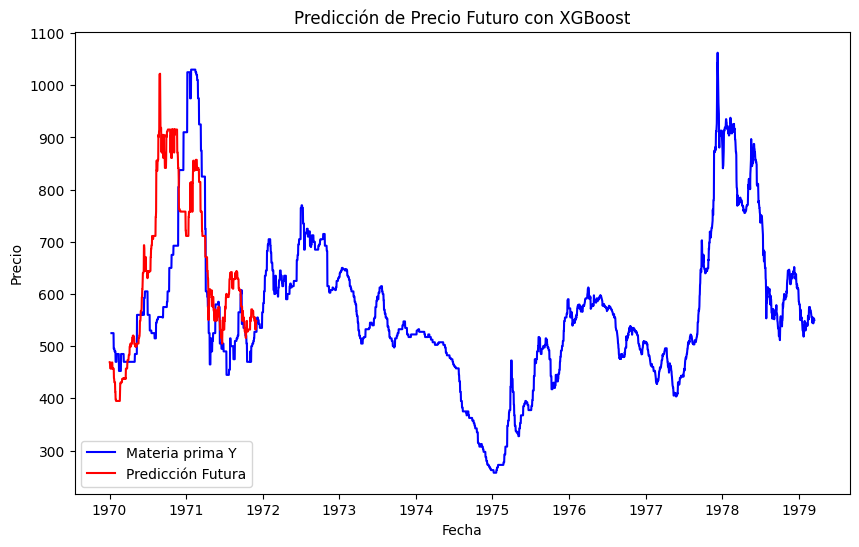

In [58]:
# 

# Realizar predicciones futuras para 700 días y graficar el nuevo dataset
future_days = 700

# Crear un nuevo dataframe con las características de lag
future = create_lag_features(df, lags=5)

# Estandarizar las características
X_future = future.drop(columns=['Price'])
X_future_scaled = scaler.transform(X_future)

# Realizar predicciones futuras
future['Prediction'] = model.predict(X_future_scaled)

# Crear un rango de fechas futuras
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_days + 1, closed='right')

# Asignar las fechas al dataframe de predicciones futuras
future = future.tail(future_days)
future['Date'] = future_dates
future.set_index('Date', inplace=True)

# Mostrar las predicciones futuras
future.head()


# Graficar las predicciones futuras
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Price'], label='Materia prima Y ', color='blue')
plt.plot(future.index, future['Prediction'], label='Predicción Futura', color='red')
plt.title('Predicción de Precio Futuro con XGBoost')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()



## Valor predicciones

In [59]:
# IMPRIMIR ULTIMO VALOR DE LA PREDICCION
print(future.tail(1))

                               Price  lag_1   lag_2   lag_3  lag_4   lag_5  \
Date                                                                         
1971-12-02 00:00:00.000003361  550.0  552.5  553.33  551.58  545.0  543.67   

                               lag_6  lag_7  lag_8  lag_9  Prediction  
Date                                                                   
1971-12-02 00:00:00.000003361  549.0  555.0  545.0  545.0  548.399963  


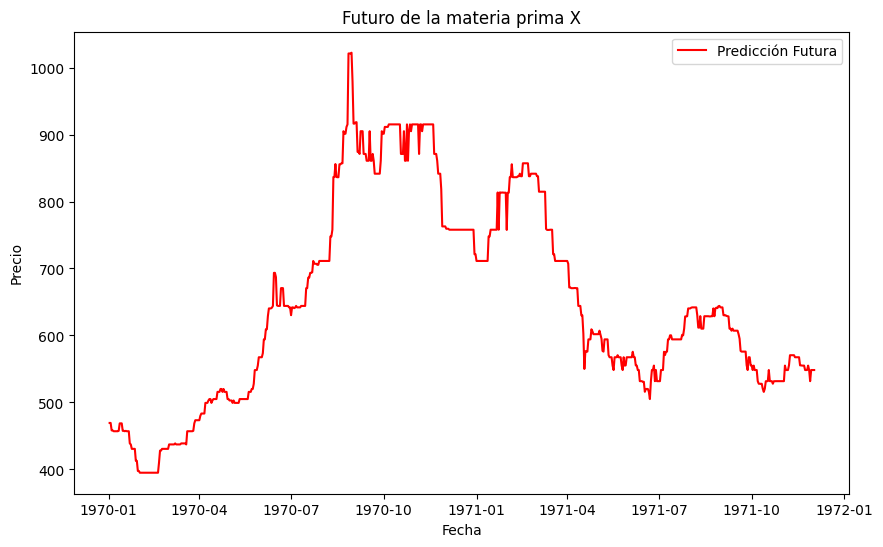

In [60]:
# graficar SOLAMENTE las predicciones futuras
plt.figure(figsize=(10, 6))
plt.plot(future.index, future['Prediction'], label='Predicción Futura', color='red')
plt.title('Futuro de la materia prima X')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()

---

---